# TFIDF + K-Means Short Text Clustering

Text clustering using sklearn tfidf and homemade k-means algorithm impletemented on PyTorch. Ideas and experiments were first conducted here.

K-means algorithm can be tremendously accelerated through CUDA, which  is why CUDA support for PyTorch is strongly suggested.


<br />

**Requirements:**

Python 3.x

PyTorch 1.x

CUDA (strongly suggested)

sklearn

matplotlib

### Experiments are done on Google Colab

A big shout out to Google Colab for providing free yet powerful jupyter notebook environment for student experimenting purposes.

**Resources:**

CPU: Intel Xeon @ 2.30GHz (x2)

RAM: 12.72 GB

GPU: Tesla T4 (16GB)

In [0]:
"from google.colab import drive
drive.mount('/content/drive')

google_drive_path = '/content/drive/My Drive/Colab Notebooks/'

## Preperation

Import dependencies and set up basic arguments and CUDA

In [0]:
from argparse import Namespace
import torch
from sklearn import metrics
from sklearn.feature_extraction.text import TfidfVectorizer
# from sklearn.decomposition import PCA # not worth it
import json
import math
import random
import time
import matplotlib.pyplot as plt
from statistics import mean 

In [4]:
# Set Numpy and PyTorch seeds
def set_seeds(seed, cuda):
    torch.manual_seed(seed)
    if cuda:
        torch.cuda.manual_seed_all(seed)

args = Namespace(
    seed=1234,
    cuda=True,
    train_tokens_file=google_drive_path + 'dm-homework3/train_tokens.json',
    train_topics_file=google_drive_path + 'dm-homework3/train_topics.json',
    vocab_file=google_drive_path + 'dm-homework3/vocab.json',
    output_file=google_drive_path +'dm-homework3/output.json',
)

# Set seeds
set_seeds(seed=args.seed, cuda=args.cuda)

# Check CUDA
if not torch.cuda.is_available():
    print("CUDA not available")
    args.cuda = False
args.device = torch.device("cuda" if args.cuda else "cpu")
print("Using CUDA: {}".format(args.cuda))

Using CUDA: True


In [0]:
def load_array(file):
    with open(file, 'r') as fp:
        array = [json.loads(line.strip()) for line in fp.readlines()]
    return array

## Data Preparation

Original data is provided in a way that every item is presented as a list of token ids, which failed to meet the requirements of TF/IDF input.

Using `vocab.json`, we can convert id list into the full text. I did so by writing class `Vocabulary`.

In [0]:
train_tokens_list = load_array(args.train_tokens_file)

In [0]:
# Load vocab list from `vocab.json`
vocab_list = load_array(args.vocab_file)

In [0]:
class Vocabulary(object):
  def __init__(self, vocab):
    self.vocab = vocab
  
  # Convert id list into full text
  def getTextFromTokenIds(self, tokenIds: list):
    vocab = self.vocab
    vocab_len = len(vocab)
    
    return ' '.join([vocab[i][0] if i < vocab_len and i >= 0 else '' for i in tokenIds])

In [0]:
# Instantiate `Vocabulary`
vocab = Vocabulary(vocab_list)

In [0]:
train_tokens_list[0]

train_texts = []

# Convert every item of `train_tokens_list` into text and add it to `train_texts`
for line in train_tokens_list:
  train_texts.append(vocab.getTextFromTokenIds(line["tokenids"]))

In [123]:
train_texts[:10]

['guy sudden feel world servic',
 'bbc radio servic inform tragedi review bbc radio servic',
 'save bbc world servic drama inquiri announc world servic slash spend',
 'bbc face cut pattern emerg money',
 'listen bbc world servic media guardian',
 'news bbc cut affect guid',
 'analysi bbc cut onlin budget',
 'bbc mortgag save world servic',
 'william face tori critic bbc world servic cut conduct inquiri',
 'bbc world servic axe quarter job']

## Feature Engineering

Using TF/IDF to both encode texts and extract limited features.

Instead of using word2vec this time, I chose to adopt tfidf. By analyzing the original data in the text form, I noticed the token words are most imcomplete(likely missing letters) and each item can hardly be considered a sentence. 

So it's almost impossible to use a trained word2vec model since the vocabulary simply wouldn't fit. Neither is it reasonable to train a word2vec model from scratch since the original data isn't big enough and items aren't coherent sentences.

### TF/IDF

TF/IDF (Term frequency–Inverse document frequency) is a numerical statistic that is intended to reflect how important a word is to a document in a collection or corpus. 

Instead of simply counting word frequencies, TF/IDF indicates that more frequency of a word's appearance doesn't necessarily mean more importance of that word. For instance, words like 'computer', 'device', 'network'... are not considered English stopwords. However when it comes to CS related papers, those words are commonly seen and most likely frequently appearing. But they wouldn't be considered 'key words' of the papers,  I.e., they should not be considered as features.

The key words we are looking for are those that are frequently seen in one item but much less so in the whole dataset. To this extent, TF/IDF is relatively explainable.

Definitions:

#### Term Frequency

$$ tf(t,d)=f_{t,d} $$

with $ f_{t,d} $ denoting  the number of times that term t occurs in document d

#### Inverse Document Frequency

$$ idf(t,D)=log \frac {N}{|\{d \in D:t \in d\}|} $$

with 

$N$: total number of documents in the corpus

 $|\{d \in D: t \in d\}|$  : number of documents where the term $t$ appears. If the term is not in the corpus, this will lead to a division-by-zero. It is therefore common to adjust the denominator to $1+|\{d \in D: t \in d\}|$
 
 #### Term frequency–Inverse document frequency
 
 $$tfidf(t,d,D)=tf(t,d)*idf(t,D)$$



### Using TF/IDF implementation from sklearn

In [0]:

tfidf = TfidfVectorizer(binary=False,decode_error='ignore',stop_words='english', max_features=1200) # extract 1200 features

vc = tfidf.fit_transform(train_texts).todense()

# convert to torch.Tensor
Input = torch.from_numpy(vc).to(args.device)

## Clustering using K-Means

K-means is a simple, well-explainable clustering algorithm.

Instead of using what comes with sklearn, I implemented K-means algorithm myself using PyTorch. The benefit of doing so is the ability to utilize GPU computing, which is almost 10 times faster than CPU.

### Euclidean Distance

In k-means, we need to calculate the distance between two points. We are using `Euclidean Distance` here:

$$ ρ= \sqrt { \sum_{i \in D}{(a_{1i} - a_{2i})^2}} $$


### K-means Algorithm

Given an initial set of k means $c_1^{(1)},…,c_k^{(1)}$, the algorithm proceeds by alternating between two steps:

- Calculate mean of points in each cluster: center point

 $$ c_i^{(n)}=\sum_{k \in D_i}{x_k^{(n-1)}} / |D_i| $$
 
- Seperate points into new clusters

     for each point $x_i$, the new cluster it belongs to:
 
    $$ \arg_d\min {ρ(x_i,c_d^{(n)})}  $$






In [0]:
# Calculate the euclidean distance between x and y
def pairwise_distance(x, y):
	x = x.unsqueeze(dim=1)
	y = y.unsqueeze(dim=0)

	dis = (x-y)**2.0
	dis = dis.sum(dim=-1).squeeze()
	return dis

In [0]:
# Pick random centers for the first iteration
def k_means_pick_centers(inputs, n_clusters):
  item_count = len(inputs)
  center_indexes = random.sample(range(item_count), n_clusters)
  
  return torch.stack([inputs[i] for i in center_indexes])

**Center Shift**

One of the conditions for K-means algorithm to stop is that the center of each cluster no longer shifts. To measure the shift of centers during iterations, we define `Center Shift` as:

$$\sum_{i \in C}{ρ(c_i^{(n)},c_i^{(n-1)})}$$

In [0]:
# Calculate shift
def k_means_center_shift(centers_x, centers_y):
  return torch.sum(torch.sqrt(torch.sum((centers_x - centers_y) ** 2, dim=1)))

In [0]:
def k_means(inputs, n_clusters, max_cycles = float('inf'), tol=1e-4):
  since = time.time()
  
  cycle_no = 0
  
  # Initalize centers by randomly picking
  centers = k_means_pick_centers(inputs, n_clusters)
  
  while True:
    # Calculate euclidean distance
    dis = pairwise_distance(inputs, centers)
    
    # Seperate points into new cluster by picking the nearest center
    choice_cluster = torch.argmin(dis, dim=1)
    centers_pre = centers.clone()
    
    # Calculate new center by calculate each cluster's average
    for index in range(n_clusters):
      selected = torch.nonzero(choice_cluster==index).squeeze()
      selected = torch.index_select(inputs, 0, selected)
      centers[index] = selected.mean(dim=0)
    
    # Calculate the Center Shift
    center_shift = k_means_center_shift(centers, centers_pre)
    
    if math.isnan(center_shift):
      raise Exception('Computing Error: invalid `nan` value, please restart')
      
    
    print('Cycle {}{}, Center Shift: {:.4f}'
          .format(cycle_no, "/" + str(max_cycles) 
                  if max_cycles < float('inf') else "", center_shift))
    
    # Stop when reaches min center_shift
    if center_shift ** 2 < tol:
      break
      
    cycle_no+=1
    # Stop when reaches max cycles
    if cycle_no >= max_cycles:
      break
  
  time_elapsed = time.time() - since
  print('========================================')
  print('Training complete in {:.0f}m {:.0f}s'.format(
            time_elapsed // 60, time_elapsed % 60))
  return choice_cluster, centers

### Run Clustering Process

Thanks to CUDA, the algorithm cost only 1s to finish! This is blazing fast!!!

In [143]:
labels, centers = k_means(Input, n_clusters=65,tol=1e-4)

Cycle 0 Center Shift: 50.2960
Cycle 1 Center Shift: 9.7475
Cycle 2 Center Shift: 6.6516
Cycle 3 Center Shift: 4.2767
Cycle 4 Center Shift: 2.5264
Cycle 5 Center Shift: 1.3981
Cycle 6 Center Shift: 0.8876
Cycle 7 Center Shift: 0.6014
Cycle 8 Center Shift: 0.7584
Cycle 9 Center Shift: 0.2983
Cycle 10 Center Shift: 0.0848
Cycle 11 Center Shift: 0.1519
Cycle 12 Center Shift: 0.0723
Cycle 13 Center Shift: 0.0370
Cycle 14 Center Shift: 0.0525
Cycle 15 Center Shift: 0.1013
Cycle 16 Center Shift: 0.0717
Cycle 17 Center Shift: 0.0000
Training complete in 0m 1s


## Evaluation

This assignment requires nmi as the index to indicate how well the algorithm does. By running nmi with provided topics_list and our clustering result, we get to know how well my algorithm performs.

In [0]:
k_docid = 'docid'
k_topic = 'topic'
k_cluster = 'cluster'

def calculate_nmi(topics_list, clusters_list):
    id2topic = dict([(d[k_docid], d[k_topic]) for d in topics_list])
    id2cluster = dict([(d[k_docid], d[k_cluster]) for d in clusters_list])
    common_idset = set(id2topic.keys()).intersection(id2cluster.keys())
    if not len(common_idset) == len(topics_list) == len(clusters_list):
        print(len(common_idset), len(topics_list), len(clusters_list))
        print('length inconsistent, result invalid')
        return 0
    else:
        topic_cluster = [(id2topic[docid], id2cluster[docid]) for docid in common_idset]
        y_topic, y_cluster = list(zip(*topic_cluster))
        nmi = metrics.normalized_mutual_info_score(y_topic, y_cluster)
        print('nmi:{}'.format(round(nmi, 4)))
        return nmi

### NMI Result:

nmi: 0.8355255595156592

In [144]:
clusters_list = []

for i, label in enumerate(labels):
  item = {
      "docid": train_tokens_list[i]["docid"],
      "cluster": label.item(),
  }
  
  clusters_list.append(item)
  
train_topics_list = load_array(args.train_topics_file)
calculate_nmi(train_topics_list, clusters_list)

nmi:0.8355


/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


0.8355255595156592

## Attempt to find the best max_feature

I used `1200` as the max_feature when apply tfidf up above without knowing whether it is exactly the best value for this parameter or not. To find out the best value here, I wrote a max_feature_finder to iterate through numbers and help us find out the best-suited.

In [0]:
from contextlib import contextmanager
import sys, os

# To mute output of k_means
@contextmanager
def suppress_stdout():
  with open(os.devnull, "w") as devnull:
    old_stdout = sys.stdout
    sys.stdout = devnull
    try:  
      yield
    finally:
      sys.stdout = old_stdout

# Run k_means once with `feature` as the max_feature
def train_once(feature):
  tfidf = TfidfVectorizer(binary=False,decode_error='ignore',stop_words='english', max_features=feature)
  vc = tfidf.fit_transform(train_texts).todense()
  Input = torch.from_numpy(vc).to(args.device)

  try:
    labels, centers = k_means(Input, n_clusters=65,tol=1e-4)
  except:
    try:
      labels, centers = k_means(Input, n_clusters=65,tol=1e-4)
    except:
      try:
        labels, centers = k_means(Input, n_clusters=65,tol=1e-4)
      except:
        labels, centers = k_means(Input, n_clusters=65,tol=1e-4)


  clusters_list = []
  for i, label in enumerate(labels):
    item = {
        "docid": train_tokens_list[i]["docid"],
        "cluster": label.item(),
    }
    clusters_list.append(item)

  train_topics_list = load_array(args.train_topics_file)

  nmi = calculate_nmi(train_topics_list, clusters_list)
  return nmi

def max_feature_finder(feature_slice: slice):
  features = []
  nmis = []
  
  best_nmi = 0
  best_feature = 0
  
  for feature in range(0, feature_slice.stop)[feature_slice]:
    sub_nmis = []
    
    # For every max_feature value, we run k_means 10 times and calculate the average nmi
    for i in range(10):
      with suppress_stdout():
        sub_nmis.append(train_once(feature))
    
    nmi = mean(sub_nmis)
    
    features.append(feature)
    nmis.append(nmi)
    
    # Record the best nmi
    if nmi > best_nmi:
      best_nmi = nmi
      best_feature = feature
    
    print('{} Features nmi: {:.8f}'.format(feature, nmi))
  
  # Plot nmi for each feature value
  plt.plot(features, nmis)
  plt.show()
  
  # Show best
  print('Best max features: {}, with best nmi: {:.4f}'.format(best_feature, best_nmi))
  
  return features, nmis

### Usage

The function accept a slice parameter. `slice(600, 1300, 10)` means it will try from 600 to 1300 with the step of 10, namely 600, 610, 620...1280, 1290.
It will plot the nmi for every max_feature it tried and print the best one.

/usr/local/lib/python3.6/dist-packages/sklearn/metrics/cluster/supervised.py:844: FutureWarning: The behavior of NMI will change in version 0.22. To match the behavior of 'v_measure_score', NMI will use average_method='arithmetic' by default.
  FutureWarning)


600 Features nmi: 0.80496956
610 Features nmi: 0.81303784
620 Features nmi: 0.81085147
630 Features nmi: 0.81408146
640 Features nmi: 0.81051533
650 Features nmi: 0.81732301
660 Features nmi: 0.81586393
670 Features nmi: 0.81135917
680 Features nmi: 0.81274930
690 Features nmi: 0.82172397
700 Features nmi: 0.82043943
710 Features nmi: 0.80657400
720 Features nmi: 0.81406979
730 Features nmi: 0.80636134
740 Features nmi: 0.81705683
750 Features nmi: 0.82226578
760 Features nmi: 0.80433317
770 Features nmi: 0.81435377
780 Features nmi: 0.81695370
790 Features nmi: 0.81592227
800 Features nmi: 0.81085422
810 Features nmi: 0.81623050
820 Features nmi: 0.82238620
830 Features nmi: 0.81254081
840 Features nmi: 0.81284522
850 Features nmi: 0.81628870
860 Features nmi: 0.81704296
870 Features nmi: 0.81636145
880 Features nmi: 0.81587805
890 Features nmi: 0.81875719
900 Features nmi: 0.81276931
910 Features nmi: 0.81706750
920 Features nmi: 0.79832091
930 Features nmi: 0.81444207
940 Features n

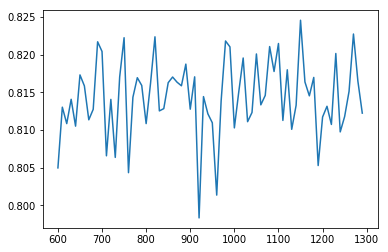

Best max features: 1150, with best nmi: 0.8246


([600,
  610,
  620,
  630,
  640,
  650,
  660,
  670,
  680,
  690,
  700,
  710,
  720,
  730,
  740,
  750,
  760,
  770,
  780,
  790,
  800,
  810,
  820,
  830,
  840,
  850,
  860,
  870,
  880,
  890,
  900,
  910,
  920,
  930,
  940,
  950,
  960,
  970,
  980,
  990,
  1000,
  1010,
  1020,
  1030,
  1040,
  1050,
  1060,
  1070,
  1080,
  1090,
  1100,
  1110,
  1120,
  1130,
  1140,
  1150,
  1160,
  1170,
  1180,
  1190,
  1200,
  1210,
  1220,
  1230,
  1240,
  1250,
  1260,
  1270,
  1280,
  1290],
 [0.8049695618532565,
  0.8130378370019395,
  0.8108514712924119,
  0.8140814615006413,
  0.8105153269285088,
  0.8173230056592792,
  0.8158639342134045,
  0.8113591693027571,
  0.8127493048969663,
  0.821723965971545,
  0.8204394256399398,
  0.806573997957663,
  0.8140697912834038,
  0.8063613436107882,
  0.8170568336252635,
  0.8222657755384761,
  0.8043331691336507,
  0.8143537733343083,
  0.8169536959908975,
  0.8159222741871444,
  0.8108542183245468,
  0.816230499936343

In [120]:
max_feature_finder(slice(600, 1300, 10))

But unfortunately the nmi is random enough. This probably means the max_feature isn't the key factor that affects nmi here. It's possible that the bottleneck lies in K-means algorithm itself.

## Conclusion

I've run this algorithm multiple times, the best nmi I could get is 0.84584795. The average is around 0.82.

But the cost of time is significantly cheap, it only cost 1 second to run the algorithm. This is mainly due to the high performance of CUDA on GPU.